<a href="https://colab.research.google.com/github/mingxuan-yi/Bayesian-learning/blob/master/Tutorial_rectified_flow_with_nonparametric_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rectified Flow
This jupyter notebook contains simple tutorial code for Rectified Flow proposed in '[Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow](https://arxiv.org/abs/2209.03003)'.

The problem here is to learn an ODE $\dot Z_t = v(Z_t, t) $ to transfer data from $\pi_0$ to $\pi_1$, where both $\pi_0$ and $\pi_1$ are unknown and empirically observed through a set of points.

The velocity field $v(z,t)$ in rectified flow can be fitted with either kernel method or deep neural networks. This tutorial illustrates the use of the Nadaraya–Watson style non-parametric estimator in the paper.


## Generating Distribution $\pi_0$ and $\pi_1$
We generate $\pi_0$ and $\pi_1$ as two Gaussian mixture models with different modes.

We sample 10000 data points from $\pi_0$ and $\pi_1$, respectively,
and store them in ```samples_0```, ```samples_1```.

Shape of the samples: torch.Size([10000, 2]) torch.Size([10000, 2])


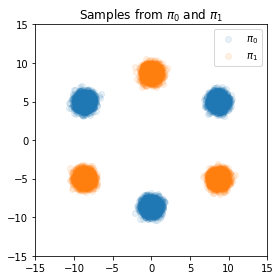

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F

D = 10.
M = D+5
VAR = 0.3
DOT_SIZE = 4
COMP = 3

initial_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
initial_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., D / 2.], [-D * np.sqrt(3) / 2., D / 2.], [0.0, - D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
initial_model = MixtureSameFamily(initial_mix, initial_comp)
samples_0 = initial_model.sample([10000])

target_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
target_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., - D / 2.], [-D * np.sqrt(3) / 2., - D / 2.], [0.0, D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
target_model = MixtureSameFamily(target_mix, target_comp)
samples_1 = target_model.sample([10000])
print('Shape of the samples:', samples_0.shape, samples_1.shape)

plt.figure(figsize=(4,4))
plt.xlim(-M,M)
plt.ylim(-M,M)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(samples_0[:, 0].cpu().numpy(), samples_0[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')
plt.legend()

plt.tight_layout()

## Define the Flow Model

Given empirical observations of $X_0\sim \pi_0$ and $X_1\sim \pi_1$,
the rectified flow induced from $(X_0,X_1)$
is an ordinary differentiable model (ODE)
on time $t\in[0,1]$,
$$
d Z_t = v^X(Z_t, t) d t,
$$
which $v$ is set in a way that ensures that $Z_1$ follows $\pi_1$ when $Z_0 \sim \pi_0$. Let $X_t = t X_1 + (1-t)X_0$ be the linear interpolation of $X_0$ and $X_1$. Then $v$ is given by
$$
v^X(z,t) = \mathbb{E}[X_1 - X_0 ~|~ X_t = z  ] =  \arg\min_{v} \int_0^1 \mathbb{E}[|| X_1-X_0 - v(X_t,t) ||^2] \mathrm{d} t,
$$
where the (conditional) expectation is w.r.t. the joint distribution of $(X_0,X_1)$.


Following the conditional expectation form above, we can estimate $v^X$ with a simple locally linear, Nadaraya–Watson style non-parametric estimator:
$$
v^X(z,t)
\approx   \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1} \left [{\frac{X_1-z}{1-t}\omega_h(X_t, z)} \right ],
~~~~\text{with}~~~~
\omega_h(X_t, z) = \frac{\kappa_h(X_t, z)}{\mathrm{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1}[{\kappa_h( X_t, z)}]},  
$$
where $\kappa_h(x,z)$ is a smoothing kernel with a bandwith parameter $h>0$
that measures the similarity between $a$ and $b$.  We use the Gaussian RBF kernel $\kappa_h(x, z) = \exp(-||x-z||^2/2h^2)$.

To see why this estimator makes sense, we just need to note that when $h\to 0$, $\kappa(x,z)$ approaches to the delta function $\delta(x,z)$, and $\frac{X_1-z}{1-t} = X_1- X_0$ if $z = X_t$.

In practice, we replace the expectations with empirical averaging.


In [ ]:
def rbf_kernel(a, b, h):
    norm = torch.norm(a-b, dim=-1, keepdim=False)
    log_kappa = (-1.) * norm.pow(2) / (2. * h)

    return log_kappa

class NW(nn.Module):
    def __init__(self, pairs, sample_size, bandwidth=1.):
        super().__init__()
        self.pairs = pairs
        self.number_of_pairs = self.pairs.shape[0]
        self.sample_size = sample_size
        self.h = bandwidth

    def forward(self, x_input, t):
        indices = torch.randperm(self.number_of_pairs)[:self.sample_size]
        pi_0_sample = self.pairs[indices, 0].detach().clone()
        pi_1_sample = self.pairs[indices, 1].detach().clone()
        pi_0_sample = pi_0_sample[None, :, :].repeat(x_input.shape[0], 1, 1)
        pi_1_sample = pi_1_sample[None, :, :].repeat(x_input.shape[0], 1, 1)
        x_input = x_input[:, None, :].repeat(1, self.sample_size, 1)
        x_t = t * pi_1_sample + (1.-t) * pi_0_sample
        log_kappa = rbf_kernel(x_t.detach().clone(), x_input.detach().clone(), self.h)
        omega = torch.softmax(log_kappa, dim=-1) * self.sample_size  ### multiplying self.sample_size because the denominator in softmax is sum, not mean

        v = (pi_1_sample - x_input) / (1.-t) * omega[:,:,None]
        v = v.mean(dim=1, keepdim=False)

        return v

Then we define the rectfied flow class.
Note that we don't need training.

In [ ]:
class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z.shape[0]

    traj.append(z.detach().clone())
    for i in range(N):
      t = i / N
      pred = self.model(z, t)
      z = z.detach().clone() + pred * dt

      traj.append(z.detach().clone())

    return traj

Misc. code for plotting figures.

In [ ]:
@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)

  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)

  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(30):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

## 1-Rectified Flow
We start by generating the pairs $(X_0, X_1)$ by pooling randomly sampled points from sample_0 and sample_1. So $(X_0,X_1)$ forms an independent coupling of $\pi_0$ and $\pi_1$.



In [ ]:
x_0 = samples_0.detach().clone()[torch.randperm(len(samples_0))]
x_1 = samples_1.detach().clone()[torch.randperm(len(samples_1))]
x_pairs = torch.stack([x_0, x_1], dim=1)
print(x_pairs.shape)

torch.Size([10000, 2, 2])


We create ```rectified_flow_1``` with our ```NW``` estimator based on $(X_0,X_1)$ above.

In [ ]:
rectified_flow_1 = RectifiedFlow(model=NW(pairs=x_pairs, sample_size=4096, bandwidth=0.001))

We run the Euler method to solve the ODE with $N=100$ steps to generate samples from 1-Rectified Flow.

Orange dots = samples from $\pi_0$

Blue dots   = samples from $\pi_1$

Green dots  = samples from 1-Rectified Flow

1-Rectified Flow successfully learned a velocity field $v(Z_t, t)$ that can transport $\pi_0$ to $\pi_1$.

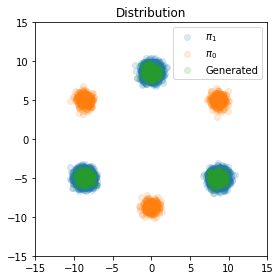

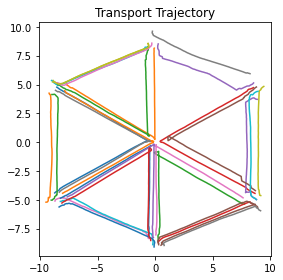

In [ ]:
draw_plot(rectified_flow_1, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=100)

We can see that the trajectories above fit well on the trajectories of linear intepolation of data, but are "rewired" in the center when the trajectories are intersect. Hence, the resulting trajectories are either (almost)straight, or has a ">" shape.

Due to the non-straight ">"-shape paths, if we simulate the ODE with a small step $N$, we would obtain poor performance, as shown below ($N=1$).


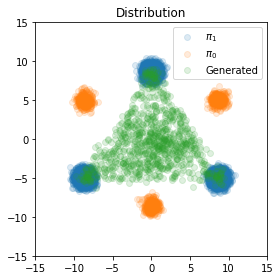

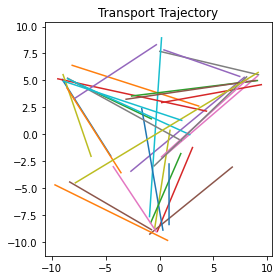

In [ ]:
draw_plot(rectified_flow_1, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=1)

## Reflow for 2-Rectified Flow
Now let's use the *reflow* procedure to get a straightened rectified flow,
denoted as 2-Rectified Flow, by repeating the same procedure on with $(X_0,X_1)$ replaced by  $(Z_0^1, Z_1^1)$, where   $(Z_0^1, Z_1^1)$ is the coupling simulated from 1-Rectified Flow.  
Specifically, we randomly sample 10000 $Z_0^1$  and generate their corresponding  $Z_1^1$ by simulating 1-Rectified Flow.

In [ ]:
z_pairs = []
for i in range(2):
  #print(i)
  z10 = samples_0.detach().clone()[i*5000: (i+1)*5000]
  #print(z10.shape)
  traj = rectified_flow_1.sample_ode(z0=z10.detach().clone(), N=100)
  z11 = traj[-1].detach().clone()
  zz = torch.stack([z10, z11], dim=1)
  z_pairs.append(zz)
z_pairs = torch.cat(z_pairs, dim=0)
print(z_pairs.shape)

torch.Size([10000, 2, 2])


In [ ]:
rectified_flow_2 = RectifiedFlow(model=NW(pairs=z_pairs, sample_size=4096, bandwidth=0.000001))

We run the Euler method to solve the ODE with $N=100$ steps to generate samples from 2-Rectified Flow.

2-Rectified Flow can also successfully learn a velocity field $v(X_t, t)$ that can transport $\pi_0$ to $\pi_1$.

The key point, however, is that the transport trajectory is now **straightened ** and hence we would not lose much accuracy even if we solve the ODE with one Euler step ($N=1$).

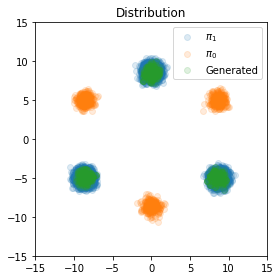

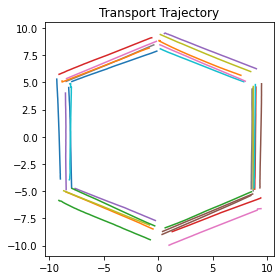

In [ ]:
draw_plot(rectified_flow_2, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=100)

So below is the result when we solve the ODE with $N=1$ step Euler step to generate samples from 2-Rectified Flow.

With the **straightened** trajectory, we get almost perfect with only  one-step generation! Thanks to the power of **Reflow** !

More croncretely, the output of the model is now $Z_1 = Z_0 + v(Z_0, 0)$.

Effectively, we have a trained a one-step model, by using ODE as an intermediate step.

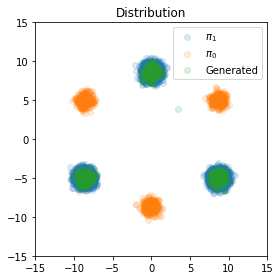

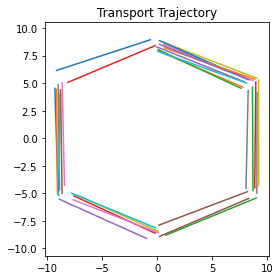

In [ ]:
draw_plot(rectified_flow_2, z0=initial_model.sample([1000]), z1=samples_1.detach().clone(), N=1)